# Installs and Requirements


In [6]:
from tensorflow.keras.layers import Normalization
from tensorflow.keras import Sequential,layers
from tensorflow.keras.layers import Dense, Flatten, SimpleRNN, LSTM, GRU,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D, Dense, Flatten
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import numpy as np
import pandas as pd
from langdetect import detect
import re
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import string # "string" module is already installed with Python
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from google.cloud import storage


In [7]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

NameError: name 'nltk' is not defined

## Import Data

In [8]:
data = 'small'

In [10]:
df = pd.read_csv(f'../raw_data/{data}.csv')

In [11]:
len(df)

28

# Preprocessing

## Functions

In [12]:
'''drop duplicates'''
def drop_duplicate_ids(df):
    df = df.drop_duplicates(subset=['id'])
    return df

'''drop y nans'''
def drop_y_nas(df):
    df = df.dropna(subset=['views'])
    return df

'''detect with try-expect'''
def detect_except(x):
    try:
        lang = detect(x)
    except:
        lang = 'Other'
        
    return lang


'''first remove of non-english rows'''
def strip_english(df):
    '''basic strip'''
    df['detect'] = df['title'].apply(detect_except)
    
    df = df[df['detect'] == 'en'] 
    return df

'''reduce dataframe to title and views'''
def reduce_features(df):
    df = df.loc[:, ['title', 'views']]
    return df

'''completed dataframe preprocessing'''
def df_preprocess(df):
    df = drop_duplicates(df)
    df = strip_english(df)
    df = reduce_features(df)
    return df

'''removes emojis'''
def emoji_strip(text):
    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text) # no emoji
    

In [13]:
'''lemmatizing'''
def lemmatize(text):
    # Lemmatizing the verbs
    verb_lemmatized = [                  
        WordNetLemmatizer().lemmatize(word, pos = "v") # v --> verbs
        for word in text
    ]

# 2 - Lemmatizing the nouns
    noun_lemmatized = [                 
        WordNetLemmatizer().lemmatize(word, pos = "n") # n --> nouns
        for word in text
    ]
    return ' '.join(text)

In [14]:
'''completed preprocessing. use with .apply() to title column'''
def preprocessing(sentence):
#     Lower
    sentence = sentence.lower()
    
    '''punctuation strip'''
    for punctuation in string.punctuation:
        sentence = sentence.replace(punctuation, '')
        
    '''strip numbers'''
    sentence = ''.join(char for char in sentence if not char.isdigit())
    
    '''emoji strip'''
    sentence = emoji_strip(sentence)
    
    '''remove chinese characters'''
    sentence=re.sub(u'(?<=[^0-9])[^\u4e00-\u9fff0-9a-zA-Z]+(?=[^0-9])',' ',sentence)
    
    '''tokenizer'''
    tokenized = word_tokenize(sentence)
    
    '''lemmatize'''
    clean_reviews = lemmatize(tokenized)
    
    return clean_reviews

### Drop duplicate ID's

In [15]:
df_drop = drop_duplicate_ids(df)

In [16]:
len(df_drop)

27

### Strip non-english titles

In [17]:
df_eng = strip_english(df_drop)

/var/folders/cq/z0dgtgp90bzbkyk56psg1hj80000gn/T/ipykernel_3457/1805765022.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['detect'] = df['title'].apply(detect_except)


In [325]:
# df_eng = df_drop

In [18]:
len(df_eng)

21

### Apply preprocessing

In [19]:
df_eng['title'] = df_eng['title'].apply(lambda x: preprocessing(x))

/var/folders/cq/z0dgtgp90bzbkyk56psg1hj80000gn/T/ipykernel_3457/749894130.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eng['title'] = df_eng['title'].apply(lambda x: preprocessing(x))


In [20]:
df_eng.head(2)

,Unnamed: 0,id,channel_id,country,channel_viewCount,channel_subscriberCount,channel_videoCount,title,published,views,detect
1,0,M6h5AS971hY,UCVFYikepF-avelvuIaQ_lHA,US,487331075,2670000,846,journey to the center of the earth full movie ...,2022-05-03T16:00:11Z,2616142,en
2,0,zeumhLatU3w,UCTFWiL4BvMuHJvfnCwmGcVg,ID,30178992,332000,220,funny cute moments baby gets jealous of parent...,2022-05-05T08:00:16Z,88411345,en


In [6]:
1*100000/60/60


27.77777777777778

In [21]:
df_eng = drop_y_nas(df_eng)

In [22]:
assert df_eng.views.isna().sum() == 0

In [23]:
df_eng["get"] =  + df["id"] +'_'+ df_eng["views"].astype(int).astype(str)

In [24]:
df_eng = df_eng.sort_values('id')

In [25]:
df_eng.head(5)

,Unnamed: 0,id,channel_id,country,channel_viewCount,channel_subscriberCount,channel_videoCount,title,published,views,detect,get
22,0,1uQztB72wJc,UCbe_N5SULIdKlO_e-g7RBhQ,US,67242993,417000,515,quotall mayweather did was runquot,2022-05-05T01:06:35Z,4160,en,1uQztB72wJc_4160
26,0,5QKCbMR-bWM,UCaObQR6nzeot-7kb0Cmcl1Q,PK,9558722,55100,332,my family short lines in english lines essay o...,2022-05-04T13:00:02Z,107249,en,5QKCbMR-bWM_107249
5,0,6e7_piGjkbk,UCzpp09_6XZzYM3HYsr3m29A,US,36233265,2530000,79,try not to say wow,2022-05-02T21:48:55Z,3840994,en,6e7_piGjkbk_3840994
12,0,9Yr5LtCy4xg,UCrp_UI8XtuYfpiqluWLD7Lw,US,1515353879,2290000,92780,half the us market is in a bubble top investor...,2022-05-02T22:20:22Z,50813,en,9Yr5LtCy4xg_50813
9,0,BJ_n5bVA9g4,UCrp_UI8XtuYfpiqluWLD7Lw,US,1515353879,2290000,92780,its not surprising were seeing a steeper curve...,2022-05-04T20:46:42Z,26912,en,BJ_n5bVA9g4_26912


In [26]:
videos_to_pick = set(df_eng['get'])

In [27]:
bucket = storage.Client().get_bucket('mvp_youtube_optimizer')
images = []
ids = []
for blob in tqdm(bucket.list_blobs(prefix = data)):
    long_filename = blob.name
    filename = long_filename.strip(f'{data}/')
    last_underscore = filename.rfind('_')
    video_id = filename[0:last_underscore]
    if filename in videos_to_pick:
        array = np.array(cv2.imdecode(np.asarray(bytearray(blob.download_as_string()), dtype=np.uint8), -1))
        if array.shape == (180, 320, 3):
            images.append(array)
            ids.append(video_id)

27it [00:02, 12.90it/s]


In [28]:
assert len(ids) == len(images)

In [29]:
df_match = df_eng[df_eng['id'].isin(ids)]

In [30]:
assert list(df_match.id) == ids

In [31]:
y = df_match.views
X_nlp = df_match.title

# Train Test Split

In [32]:
from sklearn.model_selection import train_test_split
X_train_images, X_test_images,X_train_nlp,X_test_nlp, y_train, y_test = train_test_split(images, X_nlp,y,test_size=0.2, random_state=0)

# Baseline

In [33]:
baseline = (abs(y_test-y_train.mean())).mean()
baseline

22710886.5

# Graphs

In [34]:
def plot_loss_mse(history):
    # fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    # ax1.set_ylim(ymin=0, ymax)
    plt.legend(['Train', 'Validation'], loc='best')
    plt.grid(axis="x",linewidth=0.5)
    plt.grid(axis="y",linewidth=0.5)    

    
    # ax2.plot(history.history['mse'])
    # ax2.plot(history.history['val_mse'])
    # ax2.set_title('MSE')
    # ax2.set_ylabel('MSE')
    # ax2.set_xlabel('Epoch')
    # ax2.set_ylim(ymin=0, ymax=200)
    # ax2.legend(['Train', 'Validation'], loc='best')
    # ax2.grid(axis="x",linewidth=0.5)
    # ax2.grid(axis="y",linewidth=0.5)    

    plt.show()

# Image


In [35]:
X_images_train = np.array(X_train_images)
X_images_test = np.array(X_test_images)

In [37]:
X_images_test.shape

(4, 180, 320, 3)

## Preprocess

In [38]:
def preprocess(X_train, X_test):
    X_train = preprocess_input(X_train)
    X_test = preprocess_input(X_test)
    return X_train, X_test

In [39]:
X_images_train, X_images_test = preprocess(X_images_train, X_images_test)

## Initialize

In [40]:
def base_model():
    base_model = Xception(weights="imagenet",input_shape = (180,320,3),include_top=False)
    base_model.trainable = False
    return base_model

In [41]:
def complete_model():
    model = Sequential((
        base_model(),
        #GlobalAveragePooling2D(),
        AveragePooling2D(pool_size = (3,3)),
        Flatten(),
        Dense(50,activation = 'relu'),
        Dense(1,activation = 'linear')))
    
    opt = Adam(learning_rate=0.01, 
               beta_1=0.9, 
               beta_2=0.99)
    
    model.compile(loss="mae", optimizer='adam',
                  metrics=["mse"])
    
    return model  

In [42]:
model_image = complete_model()

## Fit

In [43]:
len(X_images_train)

15

In [45]:
es = EarlyStopping(patience = 10, restore_best_weights = True)
history = model_image.fit(X_images_train,y_train, epochs = 2,batch_size = 16,validation_split=0.2, callbacks = [es])

Epoch 1/2
1/1 [==============================] - 1s 964ms/step - loss: 3220259.7500 - mse: 50616596430848.0000 - val_loss: 53373.0195 - val_mse: 8091789312.0000
Epoch 2/2
1/1 [==============================] - 1s 859ms/step - loss: 3220249.7500 - mse: 50616525127680.0000 - val_loss: 53363.7773 - val_mse: 8090935296.0000


## Model score

In [46]:
res = model_image.evaluate(X_images_test, y_test, verbose=1)

1/1 [==============================] - 0s 242ms/step - loss: 22802826.0000 - mse: 1955854555283456.0000


### Improvements on baseline

In [47]:
f'{(round((baseline-res[0])/baseline,2)*100)}%'

'-0.0%'

### Loss graphs

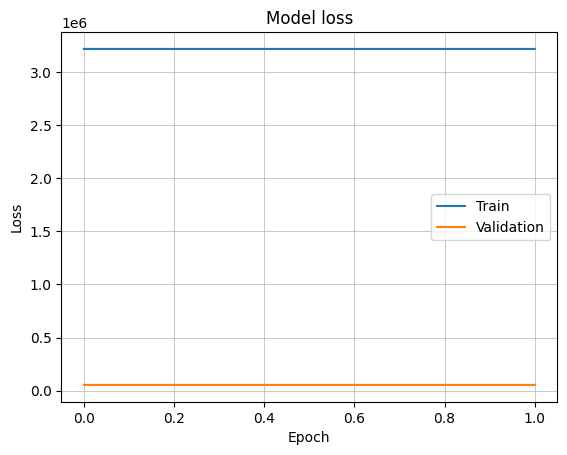

In [48]:
plot_loss_mse(history)

# Tokenizer

In [49]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X_train_nlp)



X_train_token = tokenizer.texts_to_sequences(X_train_nlp)
X_test_token = tokenizer.texts_to_sequences(X_test_nlp)

X_train_pad = pad_sequences(X_train_token, padding='post', dtype='float32')
input_length=np.array([len(i) for i in X_train_pad]).max()
X_test_pad = pad_sequences(X_test_token, padding='post', maxlen=input_length,  dtype='float32')



# X_train_tok = tk.texts_to_sequences(X_train)

# X_test_tok = tk.texts_to_sequences(X_test)

# X_train_pad=pad_sequences(X_train_tok, padding='post', dtype='float32')

# X_test_pad=pad_sequences(X_test_tok, padding='post', dtype='float32')

# CNN Model

## Input params

In [50]:
vocab_size = len(tokenizer.word_index)
vocab_size

127

In [51]:
input_length=np.array([len(i) for i in X_train_pad]).max()

In [52]:
input_length

18

## Initialize

In [53]:
embedding_size=100


def initialize_model():
    model=Sequential()
    model.add(layers.Embedding(
        input_dim=vocab_size+1, # 16 +1 for the 0 padding
        input_length=input_length, # Max_sentence_length (optional, for model summary)
        output_dim=embedding_size, # 100
        mask_zero=True, # Built-in masking layer :)
    ))

    
    model.add(layers.Conv1D(20, kernel_size=3))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(
        loss='mae',
        optimizer='adam',
        metrics='mae'
    ) 
   
    return model

## Fit

In [54]:
es=EarlyStopping(patience=10, restore_best_weights=True)
model_cnn=initialize_model()
history=model_cnn.fit(X_train_pad,
                  y_train,
                  batch_size=16,
                  validation_split=0.2,
                  callbacks=es,
                  epochs=2)

Epoch 1/2
1/1 [==============================] - 1s 553ms/step - loss: 3220278.7500 - mae: 3220278.7500 - val_loss: 53399.0000 - val_mae: 53399.0000
Epoch 2/2
1/1 [==============================] - 0s 18ms/step - loss: 3220278.7500 - mae: 3220278.7500 - val_loss: 53398.9961 - val_mae: 53398.9961


## Model score

In [55]:
res = model_cnn.evaluate(X_test_pad, y_test, verbose=0)

In [56]:
print(f'Mean absolute error : {res[0]:.4f}')

Mean absolute error : 22802858.0000


### % Improvement on baseline

In [57]:
f'{(round((baseline-res[0])/baseline,2)*100)}%'

'-0.0%'

### Loss graphs

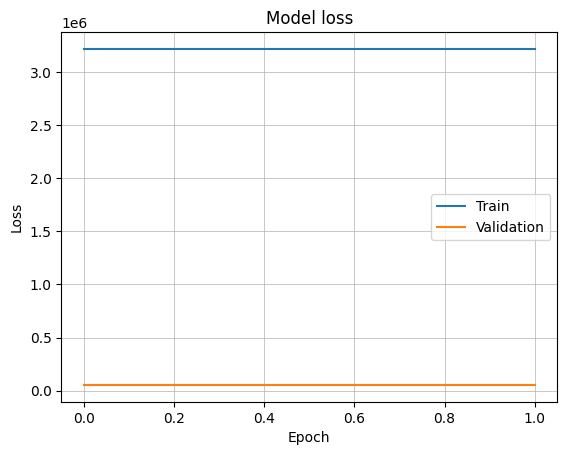

In [58]:
plot_loss_mse(history)

In [59]:
print(f'MAE reached after {len(history.epoch)} epochs')

MAE reached after 2 epochs


In [60]:
X_predict_token = tokenizer.texts_to_sequences(['total face input'])
X_predict_pad = pad_sequences(X_predict_token, maxlen = input_length, padding='post', dtype='float32')
model_cnn.predict(X_predict_pad)

1/1 [==============================] - 0s 98ms/step


array([[0.00725781]], dtype=float32)

# RNN Model

## Initialize

In [61]:
def initialize_model():
    
#     optimizer=Adam(learning_rate=0.001, clipnorm=1)
    
    embedding_size = 100

    model = Sequential()
    model.add(layers.Embedding(
        input_dim=vocab_size+1, # 16 +1 for the 0 padding
        input_length=input_length, # Max_sentence_length (optional, for model summary)
        output_dim=embedding_size, # 100
        mask_zero=True, # Built-in masking layer :)
    ))

    model.add(layers.LSTM(20,return_sequences=True))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.LSTM(20,return_sequences=False))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Dense(1, activation="linear"
#                            ,kernel_regularizer=regularizers.L1(0.001),
#                             activity_regularizer=regularizers.L2(0.001)
                          ))
    
    model.compile(
    loss='mae',
    optimizer='adam',
    metrics='mse'
    ) 
    
    return model

## Fit

In [62]:
model=initialize_model()
es=EarlyStopping(patience=10, restore_best_weights=True)

history=model.fit(X_train_pad,
                  y,
                  batch_size=128,
                  validation_split=0.2,
                  callbacks=es,
                  epochs=2)




Epoch 1/2
1/1 [==============================] - 6s 6s/step - loss: 3374443.2500 - mse: 51115441782784.0000 - val_loss: 56592.9883 - val_mse: 8126994432.0000
Epoch 2/2
1/1 [==============================] - 0s 37ms/step - loss: 3374443.2500 - mse: 51115441782784.0000 - val_loss: 56592.9805 - val_mse: 8126994432.0000


## Model score

In [63]:
res = model.evaluate(X_test_pad, y_test, verbose=0)

In [64]:
print(f'Mean absolute error : {res[0]:.4f}')

Mean absolute error : 22802858.0000


### % Improvement on baseline

In [65]:
f'{round((baseline-res[0])*100/baseline,2)}%'

'-0.4%'

### Loss graphs

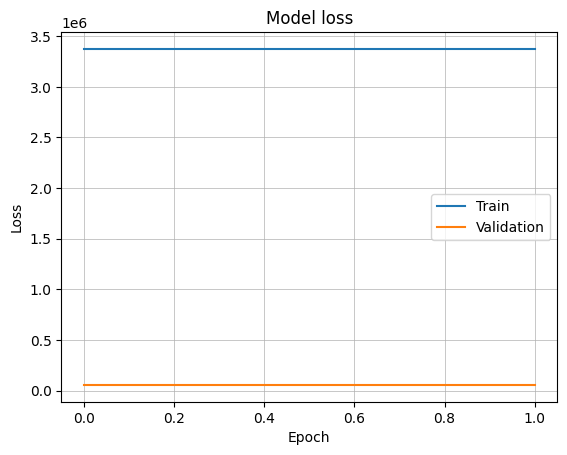

In [66]:
plot_loss_mse(history)

In [67]:
X_predict_token = tokenizer.texts_to_sequences(['new york city'])
X_predict_pad = pad_sequences(X_predict_token, maxlen = input_length, padding='post', dtype='float32')
model.predict(X_predict_pad)


1/1 [==============================] - 1s 1s/step


array([[0.01988996]], dtype=float32)

# Concat

## Inputs and outputs

In [68]:
# Define Inputs and Outputs of NLP model as with Numeric Model

# model_nlp = build_model_nlp() # comment-out to keep pre-trained weights not to start from scratch
input_NLP = model_cnn.input
output_NLP = model_cnn.output

# model_num = build_model_num() # comment-out to keep pre-trained weights not to start from scratch
input_image = model_image.input
output_image = model_image.output

In [69]:
# Let's combine the two streams of data and add two dense layers on top!
inputs = [input_NLP, input_image]

combined = layers.concatenate([output_NLP, output_image])

x = layers.Dense(10, activation="relu")(combined)

outputs = layers.Dense(1, activation="linear")(x)

model_combined = models.Model(inputs=inputs, outputs=outputs)

## Fit

In [70]:
model_combined.compile(loss="mse", optimizer=Adam(learning_rate=1e-4), metrics=['mae'])
es = EarlyStopping(patience=2)

model_combined.fit(x=[X_train_pad, X_images_train], 
                   y=y_train,
                   validation_split=0.3,
                   epochs=2,
                   batch_size=32,
                   callbacks=[es])

Epoch 1/2
1/1 [==============================] - 4s 4s/step - loss: 60739716907008.0000 - mae: 3857896.5000 - val_loss: 5408317440.0000 - val_mae: 44882.3008
Epoch 2/2
1/1 [==============================] - 1s 802ms/step - loss: 60739716907008.0000 - mae: 3857896.5000 - val_loss: 5408296960.0000 - val_mae: 44882.0391


## Model score

In [78]:
res = model_combined.evaluate(x = [X_test_pad,X_images_test], y = y_test, verbose=1)

1/1 [==============================] - 0s 337ms/step - loss: 1955856031678464.0000 - mae: 22802846.0000


In [79]:
print(f'Mean absolute error : {res[0]:.4f}')

Mean absolute error : 1955856031678464.0000


### % Improvement on baseline

In [80]:
f'{round((baseline-res[0])*100/baseline,2)}%'

'-8611975622.21%'

### Loss graphs

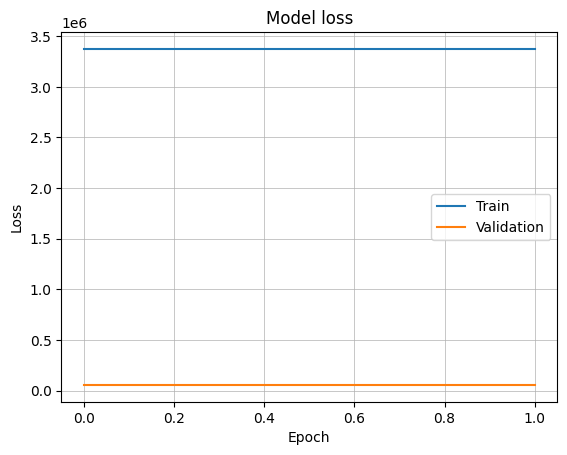

In [81]:
plot_loss_mse(history)

In [82]:
import mlflow

import os
import time
import glob
from mlflow.models.signature import infer_signature
from colorama import Fore, Style

from tensorflow.keras import Model, models

In [109]:
[X_test_pad[0:1],X_images_test[0:1]]

[array([[ 11.,   9.,   7.,   4.,  66.,   7., 107.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.]], dtype=float32),
 array([[[[-0.8117647 , -0.8509804 , -0.73333335],
          [-0.7882353 , -0.81960785, -0.67058825],
          [-0.73333335, -0.7490196 , -0.52156866],
          ...,
          [-0.41176468, -0.60784316, -0.6392157 ],
          [-0.42745095, -0.6156863 , -0.6627451 ],
          [-0.4352941 , -0.62352943, -0.67058825]],
 
         [[-0.8352941 , -0.8901961 , -0.77254903],
          [-0.8039216 , -0.8352941 , -0.6862745 ],
          [-0.7176471 , -0.7490196 , -0.52156866],
          ...,
          [-0.5372549 , -0.6862745 , -0.7254902 ],
          [-0.5372549 , -0.6862745 , -0.7411765 ],
          [-0.5529412 , -0.69411767, -0.7490196 ]],
 
         [[-0.81960785, -0.8901961 , -0.7882353 ],
          [-0.7882353 , -0.8352941 , -0.6862745 ],
          [-0.69411767, -0.73333335, -0.5058824 ],
          ...,
          [-0.6784314 , -0.73333335, -0.

In [107]:
model = models.load_model('../models/model_whole')

2022-12-04 16:49:22.066812: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-04 16:49:22.090197: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-04 16:49:22.587276: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-04 16:49:22.729782: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-04 16:49:29.962180: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _ou

TypeError: weight_decay is not a valid argument, kwargs should be empty  for `optimizer_experimental.Optimizer`.

In [77]:
print(Fore.BLUE + "\nLoad model from local disk..." + Style.RESET_ALL)

# get latest model version
model_directory = 'models'
print(f"../{model_directory}/*")
results = glob.glob(f"../{model_directory}/*")
print('results')
print(results)
model_path = sorted(results)[-1]
print(f"- path: {model_path}")

model = models.load_model(model_path)
print("\n✅ model loaded from disk")

print(model)


Load model from local disk...
../models/*
results
['../models/modelo']
- path: ../models/modelo

✅ model loaded from disk


In [101]:
np.save(f'../raw_data/single_nlp_pred.npy',X_test_pad[0:1])
np.save(f'../raw_data/single_images_pred.npy',X_images_test[0:1])

In [103]:
np.load(f'../raw_data/single_images_pred.npy').shape

(1, 180, 320, 3)

In [105]:
np.load(f'../raw_data/single_nlp_pred.npy')

array([[  1., 445.,   1.,  67., 642., 298., 101.,  20.,  98.,  47.,   9.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]],
      dtype=float32)

In [99]:
X_test_pad[0:1].save('nlp_pred.np')

AttributeError: 'numpy.ndarray' object has no attribute 'save'

In [94]:
model_combined.predict(x=[X_test_pad[0:1],X_images_test[0:1]])

1/1 [==============================] - 0s 127ms/step


array([[6.8432236]], dtype=float32)